In [ ]:
%%capture
!pip install grad-cam
!pip install ultralytics
!pip install terminaltables
!pip install iopath

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import os
import random
import torch
import cv2
import numpy as np
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
from ultralytics import RTDETR

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Change paths here

# Specify the folder containing JPG images
image_folder = "/content/drive/MyDrive/Zindi/ghana_crops/validation_fold3/images/2017"

# Load  model path
model_path = "/content/drive/MyDrive/Zindi/ghana_crops/train//weights/best.pt"


0: 640x640 20 Corn_Streaks, 6 Corn_Healthys, 1 Corn_Northern_Leaf_Blight, 2540.9ms
Speed: 19.7ms preprocess, 2540.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


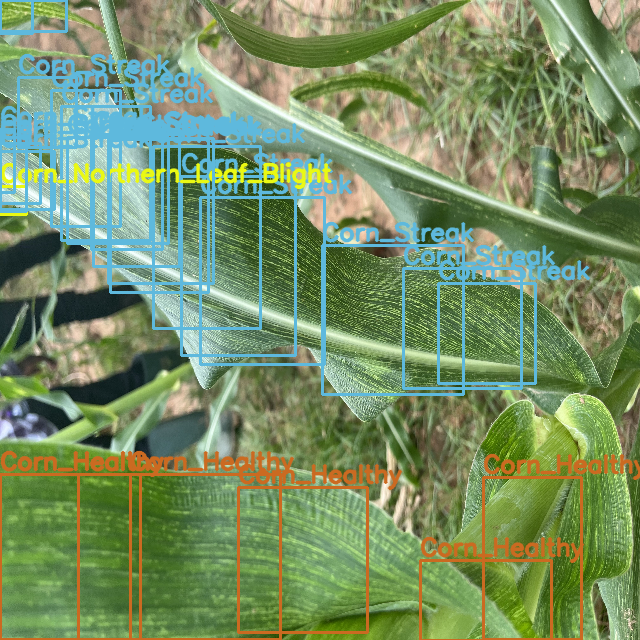

In [ ]:
COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    # Access the bounding boxes directly using .boxes attribute
    detections = results[0].boxes.data.cpu().numpy()
    boxes, colors, names = [], [], []

    for i in range(len(detections)):
        confidence = detections[i, 4] # confidence score is at index 4
        if confidence < 0.2:
            continue
        xmin, ymin, xmax, ymax = map(int, detections[i, :4])  # Bounding box coordinates
        category = int(detections[i, 5]) # Class ID is at index 5
        name = model.names[category] # Get class name using model.names
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names

def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color,
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img

# Get a list of all JPG files in the folder
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')]

if not image_files:
    raise ValueError("No JPG images found in the specified folder.")

# Randomly select an image
random_image_path = os.path.join(image_folder, random.choice(image_files))
img = np.array(Image.open(random_image_path))

# Resize and process the image
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = RTDETR(model_path)
model.eval()
model.cpu()
target_layers = [model.model.model[-1].decoder.layers[-1]]

# Run object detection
results = model([rgb_img])
boxes, colors, names = parse_detections(results)

# Draw detections on the image
detections = draw_detections(boxes, colors, names, rgb_img.copy())

# Display the result
Image.fromarray(detections)

In [ ]:
model.model.model[28].enc_output[-2]

Linear(in_features=256, out_features=256, bias=True)

In [ ]:
test = [model.model.model[28].enc_output[-2]]

In [ ]:
#target_layers = [model.model.model[-1].decoder.layers[-1]]
target_layers = [model.model.model[-2]]


0: 640x640 36 Corn_Streaks, 1 Corn_Northern_Leaf_Blight, 2344.6ms
Speed: 0.0ms preprocess, 2344.6ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 36 Corn_Streaks, 1 Corn_Northern_Leaf_Blight, 2264.8ms
Speed: 0.0ms preprocess, 2264.8ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 640)


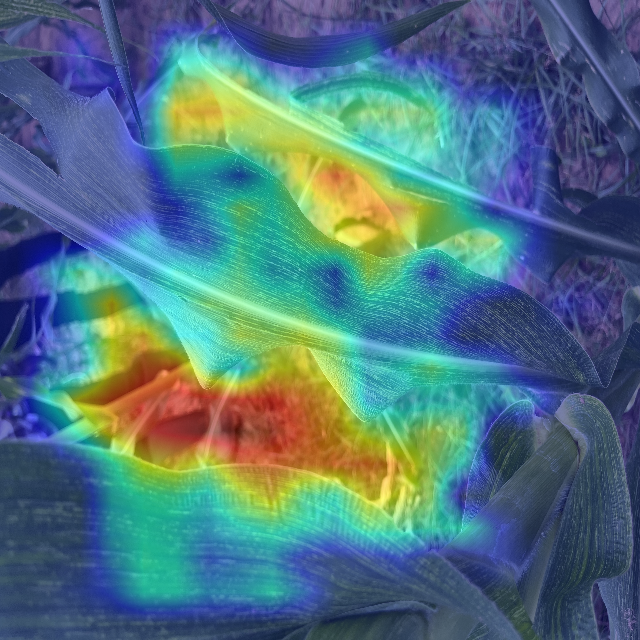

In [ ]:
cam = EigenCAM(model, target_layers)
# Add this line to get model output
outputs = model(tensor)

# Access the scores and bounding boxes from the model output dictionary and then apply cpu()
scores = outputs[0].boxes.conf  # Access confidence scores
boxes = outputs[0].boxes.xyxy  # Access bounding boxes
scores = scores.cpu() # Move scores to CPU
boxes = boxes.cpu() # Move boxes to CPU
target_categories = np.argmax(scores.data.numpy(), axis=-1) # Get target categories

# Now call the cam with the tensor input, not the outputs
grayscale_cam = cam(tensor, targets=names)[0, :, :] # Pass targets if needed by your CAM implementation
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)